In [1]:
%cd ..

/fs01/home/abbasgln/codes/medAI/projects/tta


/h/abbasgln/.conda/envs/mttt/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os
from dotenv import load_dotenv
# Loading environment variables
load_dotenv()

import torch
import torch.nn as nn
import torch.nn.functional as F
import typing as tp
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from dataclasses import dataclass, field
import logging
import wandb

import medAI
from medAI.utils.setup import BasicExperiment, BasicExperimentConfig

from utils.metrics import MetricCalculator

from timm.optim.optim_factory import create_optimizer

from einops import rearrange, repeat
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import timm

from copy import copy, deepcopy
import pandas as pd

from datasets.datasets import ExactNCT2013RFImagePatches
from medAI.datasets.nct2013 import ExactNCT2013BmodePatches
from medAI.datasets.nct2013 import (
    KFoldCohortSelectionOptions,
    LeaveOneCenterOutCohortSelectionOptions, 
    PatchOptions
)
import torchmetrics



In [3]:
LEAVE_OUT='JH'

In [4]:
from ensemble_experiment import EnsembleConfig
config = EnsembleConfig(cohort_selection_config=LeaveOneCenterOutCohortSelectionOptions(leave_out=f"{LEAVE_OUT}"),
                        # patch_config=PatchOptions(needle_mask_threshold=0.6, prostate_mask_threshold=0.9, patch_size_mm = (3,3), strides = (1.2,1.2))
)

from baseline_experiment import BaselineConfig
from torchvision.transforms import v2 as T
from torchvision.tv_tensors import Image as TVImage

class Transform:
    def __init__(selfT, augment=False):
        selfT.augment = augment
        selfT.size = (256, 256)
        # Augmentation
        selfT.transform = T.Compose([
            T.RandomAffine(degrees=0, translate=(0.2, 0.2)),
            T.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0.5),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.5),
        ])  
    
    def __call__(selfT, item):
        patch = item.pop("patch")
        patch = copy(patch)
        patch = (patch - patch.min()) / (patch.max() - patch.min()) \
            if config.instance_norm else patch
        patch = TVImage(patch)
        patch_orig_size = patch
        patch = T.Resize(selfT.size, antialias=True)(patch).float()
        
        label = torch.tensor(item["grade"] != "Benign").long()
        
        if selfT.augment:
            patch_augs = torch.stack([selfT.transform(patch) for _ in range(2)], dim=0)
            return patch_augs, patch, label, item #, patch_orig_size
        
        return -1, patch, label, item

if (config.cohort_selection_config.leave_out == "UVA"):
    config.cohort_selection_config.benign_to_cancer_ratio = 5.0     

patch_config = PatchOptions(needle_mask_threshold=-1, prostate_mask_threshold=0.9, patch_size_mm = (5,5), strides = (1,1))

test_ds_memo = ExactNCT2013RFImagePatches(
    split="test",
    transform=Transform(augment=False),
    cohort_selection_options=config.cohort_selection_config,
    # patch_options=config.patch_config,
    patch_options=patch_config,
    debug=config.debug,
)

test_ds_bmode = ExactNCT2013BmodePatches(
    split="test",
    transform=Transform(augment=False),
    cohort_selection_options=config.cohort_selection_config,
    # patch_options=config.patch_config,
    patch_options=patch_config,
)

test_loader_memo = DataLoader(
    test_ds_memo, batch_size=32, shuffle=False, num_workers=4
)

test_core_ds = test_ds_bmode.dataset.dataset

Computing positions: 100%|██████████| 616/616 [00:37<00:00, 16.50it/s]


In [5]:
from baseline_experiment import FeatureExtractorConfig

fe_config = FeatureExtractorConfig()

# Create the model
list_models: tp.List[nn.Module] = [timm.create_model(
    fe_config.model_name,
    num_classes=fe_config.num_classes,
    in_chans=1,
    features_only=fe_config.features_only,
    norm_layer=lambda channels: nn.GroupNorm(
                    num_groups=fe_config.num_groups,
                    num_channels=channels
                    )) for _ in range(5)]

# list_models: tp.List[nn.Module] = [timm.create_model(
#     fe_config.model_name,
#     num_classes=fe_config.num_classes,
#     in_chans=1,
#     features_only=fe_config.features_only,
#     ) for _ in range(5)]

CHECkPOINT_PATH = os.path.join(os.getcwd(), f'logs/tta/ensemble_5mdls_gn_3ratio_loco/ensemble_5mdls_gn_3ratio_loco_{LEAVE_OUT}/', 'best_model.ckpt')
# CHECkPOINT_PATH = os.path.join(os.getcwd(), f'logs/tta/ensemble_5mdls_gn_avgprob_3ratio_loco/ensemble_5mdls_gn_avgprob_3ratio_loco_{LEAVE_OUT}/', 'best_model.ckpt')
# CHECkPOINT_PATH = os.path.join(os.getcwd(), f'logs/tta/ensemble_5mdls_bn_1nratio_loco/ensemble_5mdls_bn_1nratio_loco_{LEAVE_OUT}/', 'best_model.ckpt')
# CHECkPOINT_PATH = os.path.join(os.getcwd(), f'logs/tta/ensemble_5mdls_gn_1ratio_loco/ensemble_5mdls_gn_1ratio_loco_{LEAVE_OUT}/', 'best_model.ckpt')

state = torch.load(CHECkPOINT_PATH)
[model.load_state_dict(state["list_models"][i]) for i, model in enumerate(list_models)]

[model.eval() for model in list_models]
[model.cuda() for model in list_models]

a = True

In [6]:
temp = 1.0
beta = 0.0
if LEAVE_OUT == "JH":
#     temp = 1.6793
#     beta = -1.0168
    temp = 0.9253
    beta = -1.0273
elif LEAVE_OUT == "PCC":
#     temp = 1.5950
#     beta = -0.8514
    temp = 1.0075
    beta = -0.8614
elif LEAVE_OUT == "PMCC":
#     temp = 0.6312
#     beta = -1.0017
    temp = 0.9020
    beta = -1.0609
elif LEAVE_OUT == "UVA":
#     temp = 0.9333
#     beta = -0.7474
    temp = 1.6528
    beta = -0.6192
elif LEAVE_OUT == "CRCEO":
#     temp = 1.2787
#     beta = -0.8716
    temp = 0.8515
    beta = -0.8461
    
temp = torch.tensor(temp).cuda()
beta = torch.tensor(beta).cuda()

In [7]:
loader = test_loader_memo
enable_pseudo_label = True
temp_scale = False
certain_threshold = 0.8
thr = 0.4

metric_calculator = MetricCalculator()
desc = "test"

for i, batch in enumerate(tqdm(loader, desc=desc)):
    images_augs, images, labels, meta_data = batch
    # images_augs = images_augs.cuda()
    images = images.cuda()
    labels = labels.cuda()
    
    adaptation_model_list = [deepcopy(model) for model in list_models] 
    [model.eval() for model in adaptation_model_list]

    
    if enable_pseudo_label:
        params = []
        for model in adaptation_model_list:
            params.append({'params': model.parameters()})
        optimizer = optim.SGD(params, lr=5e-4)
        
        # Adapt to test
        for j in range(1):
            optimizer.zero_grad()
            
            # Forward pass
            stacked_logits = torch.stack([model(images) for model in adaptation_model_list])
            if temp_scale:
                stacked_logits = stacked_logits / temp + beta
            
            # Remove uncertain samples from test-time adaptation
            avg_probs = F.softmax(stacked_logits, dim=-1).mean(dim=0)
            certain_idx = F.softmax(stacked_logits, dim=-1).mean(dim=0).max(dim=-1)[0] >= certain_threshold
            # certain_idx =  torch.sum((-avg_probs*torch.log(avg_probs)), dim=-1) <= certain_threshold
            stacked_logits = stacked_logits[:, certain_idx, ...]
            
            list_losses = []
            for k, outputs in enumerate(adaptation_model_list):
                loss = nn.CrossEntropyLoss()(stacked_logits[k, ...], (F.softmax(stacked_logits, dim=-1).mean(dim=0)[:, 1] >= thr).to(torch.long))
                list_losses.append(loss.mean())
            # Backward pass
            sum(list_losses).backward()
            optimizer.step()
        
    # Evaluate
    logits = torch.stack([model(images) for model in adaptation_model_list])
    if temp_scale:
        logits = logits / temp + beta
    losses = [nn.CrossEntropyLoss()(
        logits[i, ...],
        labels
        ) for i in range(5)
    ]
                    
    # Update metrics   
    metric_calculator.update(
        batch_meta_data = meta_data,
        probs = F.softmax(logits, dim=-1).mean(dim=0).detach().cpu(), # Take mean over ensembles
        labels = labels.detach().cpu(),
        raw_probs = F.softmax(logits, dim=-1).detach().cpu(),
    )

test:   0%|          | 0/6498 [00:00<?, ?it/s]

In [8]:
avg_core_probs_first = True
metric_calculator.avg_core_probs_first = avg_core_probs_first

# Log metrics every epoch
metrics = metric_calculator.get_metrics()

# Update best score
(best_score_updated,best_score) = metric_calculator.update_best_score(metrics, desc)

best_score_updated = copy(best_score_updated)
best_score = copy(best_score)
        
# Log metrics
metrics_dict = {
    f"{desc}/{key}": value for key, value in metrics.items()
    }

metrics_dict

{'test/patch_auroc': tensor(0.6153),
 'test/patch_accuracy': tensor(0.5785),
 'test/patch_sensitivity': tensor(0.6157),
 'test/patch_specificity': tensor(0.5412),
 'test/all_inv_patch_auroc': tensor(0.5771),
 'test/all_inv_patch_accuracy': tensor(0.5521),
 'test/all_inv_patch_sensitivity': tensor(0.5631),
 'test/all_inv_patch_specificity': tensor(0.5412),
 'test/core_auroc': tensor(0.7560),
 'test/core_accuracy': tensor(0.6487),
 'test/core_sensitivity': tensor(0.8529),
 'test/core_specificity': tensor(0.4444),
 'test/all_inv_core_auroc': tensor(0.6852),
 'test/all_inv_core_accuracy': tensor(0.6076),
 'test/all_inv_core_sensitivity': tensor(0.7708),
 'test/all_inv_core_specificity': tensor(0.4444)}

In [9]:
METRIC_CALCULATOR_PATH = f'/ssd005/projects/exactvu_pca/checkpoint_store/Mahdi/ensemble_5mdls_gn_3ratio_loco/ensemble_5mdls_gn_3ratio_loco_{LEAVE_OUT}/metric_calculator_prst.pth'

torch.save(metric_calculator, METRIC_CALCULATOR_PATH)

In [ ]:
METRIC_CALCULATOR_PATH = f'/ssd005/projects/exactvu_pca/checkpoint_store/Mahdi/ensemble_5mdls_gn_3ratio_loco/ensemble_5mdls_gn_3ratio_loco_{LEAVE_OUT}/metric_calculator_prst.pth'

metric_calculator = torch.load(METRIC_CALCULATOR_PATH)

In [53]:
test_core_ds[126]

{'patient_id': 167,
 'id': 1595,
 'loc': 'RAL',
 'grade': 'Benign',
 'pct_cancer': nan,
 'primary_grade': nan,
 'secondary_grade': nan,
 'tag': 'JH-0029_RAL',
 'case_id': 'JH-0029',
 'case_number': 29,
 'center': 'JH',
 'age': 64,
 'family_history': False,
 'psa': 26.6,
 'bmode': memmap([[161, 163, 176, ..., 181, 181, 181],
         [191, 189, 174, ..., 197, 197, 198],
         [167, 166, 153, ..., 171, 166, 165],
         ...,
         [ 88,  88,  88, ...,  93,  94,  94],
         [ 98,  97,  85, ..., 104, 108, 108],
         [ 83,  83,  81, ...,  78,  64,  62]], dtype=uint8),
 'needle_mask': memmap([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [208]:

def get_contours(mask):

    import cv2
    mask_uint8 = (mask * 255).astype('uint8')
    contours = cv2.findContours(mask_uint8, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    mask_contours = np.zeros_like(mask_uint8)
    cv2.drawContours(mask_contours, contours[0], -1, 255, 6)

    return mask_contours

In [10]:
from medAI.datasets.nct2013 import convert_physical_coordinate_to_pixel_coordinate

image = test_core_ds[126]["bmode"]
positions = test_ds_bmode.positions[126]
core_id = test_core_ds[126]['id']
_needle_mask = torch.tensor(test_core_ds[126]["needle_mask"])
needle_alpha = 0.0
needle_rgb_color = np.array([1, 1, 0]).reshape(1, 1, 3)
patch_alpha = 0.2
threshold = 0.6


H, W = image.shape
image = (image - image.min())/image.max()
image = torch.tensor(image).repeat(3, 1, 1).numpy().transpose(1, 2, 0)
_needle_mask = T.Resize((H, W), interpolation=T.InterpolationMode.NEAREST)(_needle_mask.unsqueeze(0)).permute(1, 2, 0).repeat(1,1,3).numpy()
needle_heatmap = (needle_alpha*_needle_mask*needle_rgb_color)

positions = [pos['position'] for pos in positions]
probs = torch.stack(metric_calculator.core_id_probs[core_id])
pred_labels = probs[:, 1] >= threshold

prediction_heatmap = np.zeros_like(image)
for pos, pred in zip(positions, pred_labels):
    xmin_mm, ymin_mm, xmax_mm, ymax_mm= pos
    xmin_px, ymin_px = convert_physical_coordinate_to_pixel_coordinate(
        (xmin_mm, ymin_mm), (28, 46.06), (H,W))
    xmax_px, ymax_px = convert_physical_coordinate_to_pixel_coordinate(
        (xmax_mm, ymax_mm), (28, 46.06), (H, W))
    
    prediction_heatmap[xmin_px:xmax_px, ymin_px:ymax_px, :] += np.array([1, 0, 0]).reshape(1, 1, 3) if pred else np.array([0, 0, 1]).reshape(1, 1, 3)
prediction_heatmap = patch_alpha * prediction_heatmap

heatmap = image + needle_heatmap + prediction_heatmap 



In [11]:
def create_heatmap(image, positions, needle_mask, core_id, core_id_probs, threshold=0.6, alpha=0.2, needle_alpha=0.0):
    H, W = image.shape
    image = (image - image.min())/image.max()
    image = torch.tensor(image).repeat(3, 1, 1).numpy().transpose(1, 2, 0)
    needle_mask = T.Resize((H, W), interpolation=T.InterpolationMode.NEAREST)(needle_mask.unsqueeze(0)).permute(1, 2, 0).repeat(1,1,3).numpy()
    needle_heatmap = (needle_alpha*needle_mask*np.array([1, 1, 0]).reshape(1, 1, 3))
    probs = torch.stack(core_id_probs[core_id])
    pred_labels = probs[:, 1] >= threshold

    positions = [pos['position'] for pos in positions]
    prediction_heatmap = np.zeros_like(image)
    for pos, pred in zip(positions, pred_labels):
        xmin_mm, ymin_mm, xmax_mm, ymax_mm = pos
        xmin_px, ymin_px = convert_physical_coordinate_to_pixel_coordinate(
            (xmin_mm, ymin_mm), (28, 46.06), (H,W))
        xmax_px, ymax_px = convert_physical_coordinate_to_pixel_coordinate(
            (xmax_mm, ymax_mm),(28, 46.06), (H, W))
        prediction_heatmap[xmin_px:xmax_px, ymin_px:ymax_px, :] += np.array([1, 0, 0]).reshape(1, 1, 3) if pred else np.array([0, 0, 1]).reshape(1, 1, 3)
    prediction_heatmap = alpha * prediction_heatmap

    heatmap = image + needle_heatmap + prediction_heatmap
    return heatmap

In [101]:
core_no = 493
bmode_image = test_core_ds[core_no]["bmode"]
positions = test_ds_bmode.positions[core_no]
needle_mask = torch.tensor(test_core_ds[core_no]["needle_mask"])
core_id = test_core_ds[core_no]['id']
patch_probs = metric_calculator.core_id_probs
heatmap = create_heatmap(bmode_image, positions, needle_mask, core_id, patch_probs, threshold=0.7, alpha=0.02, needle_alpha=0.05)
involvement = test_core_ds[core_no]["pct_cancer"]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Core No: 493, Involvement: 50.00')

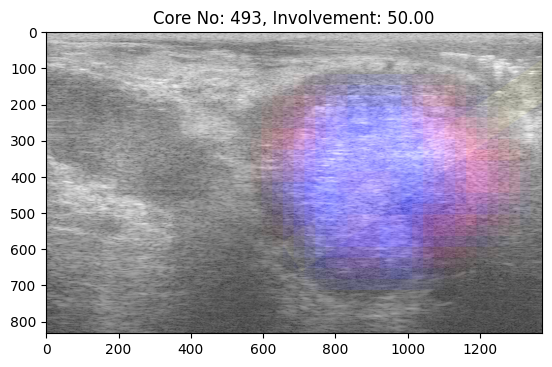

In [102]:
plt.imshow(heatmap,)
plt.title(f"Core No: {core_no}, Involvement: {involvement:.2f}")

# plt.imshow(_needle_mask, cmap="gray", alpha=0.3)

In [91]:
core_info = test_core_ds.core_info.reset_index()
core_info[core_info["grade"] != 'Benign']

,index,patient_id,id,loc,grade,pct_cancer,primary_grade,secondary_grade,tag,case_id,case_number,center,age,family_history,psa
28,1497,158,1497,RAL,GS8,20.0,4.0,4.0,JH-0006_RAL,JH-0006,6,JH,65,False,4.50
29,1498,158,1498,RAM,GS7,80.0,4.0,3.0,JH-0006_RAM,JH-0006,6,JH,65,False,4.50
30,1499,158,1499,RBL,GS7,90.0,4.0,3.0,JH-0006_RBL,JH-0006,6,JH,65,False,4.50
31,1500,158,1500,RBM,GS7,50.0,4.0,3.0,JH-0006_RBM,JH-0006,6,JH,65,False,4.50
32,1501,158,1501,RML,GS8,40.0,4.0,4.0,JH-0006_RML,JH-0006,6,JH,65,False,4.50
33,1502,158,1502,RMM,GS7,80.0,4.0,3.0,JH-0006_RMM,JH-0006,6,JH,65,False,4.50
78,1547,163,1547,LBM,GS7,20.0,3.0,4.0,JH-0020_LBM,JH-0020,20,JH,61,False,5.30
79,1548,163,1548,LML,GS7,10.0,4.0,3.0,JH-0020_LML,JH-0020,20,JH,61,False,5.30
80,1549,163,1549,LMM,GS7,20.0,3.0,4.0,JH-0020_LMM,JH-0020,20,JH,61,False,5.30
120,1589,167,1589,LAL,GS7,90.0,4.0,3.0,JH-0029_LAL,JH-0029,29,JH,64,False,26.60
